In [1]:
import numpy as np
import matplotlib.pyplot as plt

from platescheduler.scheduler import Scheduler
from observesim.weather import Weather

In [ ]:
def windowWidth(dec, designHA):
    # dec and designHA in degrees!
    # compute plates obs window in hours
    obs_win = 6 - ( np.abs(dec - 40) + np.abs(designHA))/15  # *1h
    return obs_win*15

plate_array = np.genfromtxt("/home/john/first_plates.csv", delimiter=",", dtype=None, names=True)

plate_types = [("PLATE_ID", np.int32),
               ("FIELD", np.dtype("a20")),
               ("RA", np.float64),
               ("DEC", np.float64),
               ("HA", np.float64),
               ("HA_MIN", np.float64),
               ("HA_MAX", np.float64),
               ("SKYBRIGHTNESS", np.float64),
               ("CADENCE", np.dtype("a20")),
               ("PRIORITY", np.int32)]

plates = np.zeros(len(plate_array), dtype=plate_types)
plates["PLATE_ID"] = 2e4 + np.arange(len(plate_array))
plates["FIELD"] = np.array([c.decode().strip() for c in plate_array["FIELD"]], dtype=np.dtype("a20"))
plates["RA"] = plate_array["RA"]
plates["DEC"] = plate_array["DEC"]
plates["HA"] = plate_array["HA"]
obs_win = windowWidth(plate_array["DEC"], plate_array["HA"])/2
plates["HA_MIN"] = plate_array["HA"] - obs_win
plates["HA_MAX"] = plate_array["HA"] + obs_win
plates["SKYBRIGHTNESS"] = np.array([1 if c.decode().strip() in ["RV6", "RV12", "YSO", "GG"] else 0.35 for c in plate_array["CADENCE"]])
plates["CADENCE"] = np.array([c.decode().strip() for c in plate_array["CADENCE"]], dtype=np.dtype("a20"))
plates["PRIORITY"] = plate_array["PRIORITY"]

fitsio.write("/home/john/Downloads/first_plates.fits", plates, clobber=True)

In [8]:
sched = Scheduler(platePath="/home/john/Downloads/first_plates.fits")
plate_to_cadence = {p["PLATE_ID"]: p["CADENCE"] for p in sched.plates}

# first day!
start = 59138
# take out a full moon night somewhere

mjds = np.arange(start, start+30, 1)

weather = Weather(mjd_start=start,
                  mjd_end=mjds[-1],
                  seed=1, fclear=0.5)

night_scheds = list()

weather_lost = list()

last_engineering = 0
for m in mjds[:]:
    if sched.Observer.moon_illumination(m) > 0.99:
        if m - last_engineering > 2:
            last_engineering = m
            print(f"SKIPPING {m} for eng")
            continue
    
    bright_starts, dark_starts, night_sched = sched.scheduleMjd(m)
    
    night_scheds.append(night_sched)
    
    for b in bright_starts:
        if weather.clear(b["start"], returnNext=False):
#             print("WEATHER", b["start"])
            weather_lost.append(b)
            continue
        if b["plateid"] is None:
            print(f"NO bright PLATE {float(sched.Observer.lst(b['start']))/15:5.1f} {b['start']:9.3f}")
            field = "BAD"
            pid = -1
            cadence = "BAD"
            continue
        else:
            field = sched._plateIDtoField[b["plateid"]]
            pid = b["plateid"]
            cadence = plate_to_cadence[b["plateid"]]
        sched.obs_hist[field].append(b["start"])
        
        sched._obs_query.append({"plate": pid, 
                                 "field": field, 
                                 "cadence": cadence, 
                                 "mjd": b["start"],
                                 "len": b["length"]})
    
    for b in dark_starts:
        if weather.clear(b["start"], returnNext=False):
#             print("WEATHER", b["start"])
            weather_lost.append(b)
            continue
        if b["plateid"] is None:
            print(f"NO dark PLATE {float(sched.Observer.lst(b['start']))/15:5.1f} {b['start']:9.3f}")
            field = "BAD"
            pid = -1
            cadence = "BAD"
            continue
        else:
            field = sched._plateIDtoField[b["plateid"]]
            pid = b["plateid"]
            cadence = plate_to_cadence[b["plateid"]]
        sched.obs_hist[field].append(b["start"])
        
        sched._obs_query.append({"plate": pid, 
                                 "field": field, 
                                 "cadence": cadence, 
                                 "mjd": b["start"],
                                 "len": b["length"]})


!!using psuedo-random weather!!
NO dark PLATE   5.3 59146.421
AAHHH NO AQMES PLATE 59147.32331458828
NO dark PLATE   3.0 59147.323
AAHHH NO AQMES PLATE 59148.36363039518
AAHHH NO AQMES PLATE 59149.402683546534
NO dark PLATE   5.0 59149.403
AAHHH NO AQMES PLATE 59150.44074191552
NO dark PLATE   6.0 59150.441
SKIPPING 59153 for eng


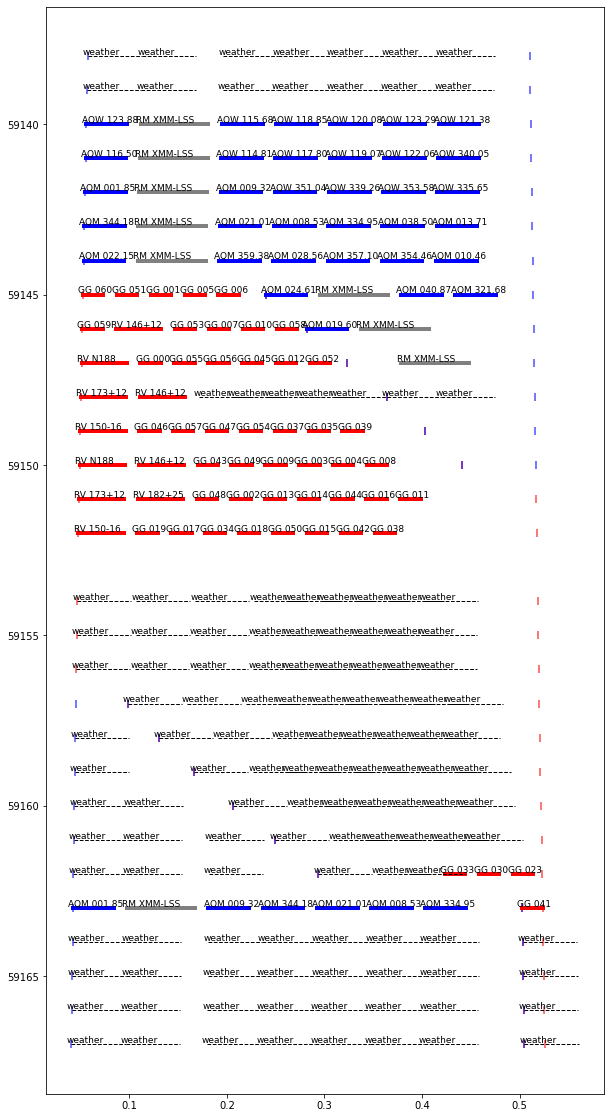

In [10]:
plt.figure(figsize=(10,20))
plt.gca().invert_yaxis()
for s in night_scheds:
    if int(s["bright_start"]) > 0:
        plt.scatter(s["bright_start"]%1, int(s["bright_start"]), marker="|", c="r", alpha=0.7, s=60)
        plt.scatter(s["bright_end"]%1, int(s["bright_end"]), marker="|", c="r", alpha=0.7, s=60)
    if int(s["dark_start"]) > 0:
        plt.scatter(s["dark_start"]%1, int(s["dark_start"]), marker="|", c="b", alpha=0.7, s=60)
        plt.scatter(s["dark_end"]%1, int(s["dark_end"]), marker="|", c="b", alpha=0.7, s=60)

for o in sched._obs_query:
    cad = o["cadence"]
    if cad in ["GG", "YSO", "RV6", "RV12"]:
        color = "r"
    elif cad == "RM":
        color = "grey"
    else:
        color = "b"
    m = o["mjd"]
    plt.text(m%1 - 0.005, int(m)-0.05, o["field"][:10].replace("_", " "), fontsize=9)
    plt.plot([m%1, m%1 + o["len"]/60/24 -20/60/24], [int(m), int(m)], linewidth=4, c=color)
#     print(f"{m:.3f}", o["len"], o["field"], o["plate"])

for w in weather_lost:
    m = w["start"]
#     print(m)
    plt.text(m%1 - 0.005, int(m)-0.05, "weather", fontsize=9)
    plt.plot([m%1, m%1 + o["len"]/60/24], [int(m), int(m)], linewidth=1, c="k", linestyle="--")

plt.savefig("oct_plate_proj.pdf")

In [4]:
len([1])

1